# Notes
* convolution: apply a sliding filter to channels (e.g. rgb) in input (e.g. image)
    * filters are typically squares (K x K)
    * weights are constant for each channel, reducing the weight matrix size greatly
* pooling: think of this like image reduction, to make inputs smaller (e.g. take average of 4 pixels to shrink image 4-fold)
* typical architecture:
    * first a series of convolution & pooling
    * then a few dense layers
        * use GlobalMaxPooling2D() layer from Keras to get correct input shape
        * leads to a 1x1xC input, i.e. each channel gets represented as 1 value
        * could also use Flatten() layer but this is less flexible for different image dimensions
    * final regression/softmax layer
* typical conventions
    * use small filters relative to input (e.g. 3x3 or 5x5)
    * increase # of feature maps as you go through conv/pooling (e.g. 32 -> 64 -> 128)
* CNNs for text
    * treat the vectorized (2d) text as basically the image
    * but use 1D convolution, since we only care about nearby text from within each input

#### text matrix
* each row is a "timepoint," i.e. words within a sentence (w1, w2 ... wn)
* each column is a different D-length vector corresponding to that word (features D1, D2, Dn)

In [1]:
# [D -> D1   D2   Dn] <br>
# [T1   w1D1 w1D2 w1Dn] <br>
# [T2   w2D1 w2D2 w2Dn] <br>
# [Tn   wnD1 wnD2 wnDn] <br>

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
                 
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy



In [25]:
# all from tf_ann notebook

articles = []
labels = []

with open('input/bbc_text_cls.csv') as f:
    running_art = ''
    for l in f.readlines()[1:]:
        if '",' not in l or '", ' in l:
            running_art += f'{l.strip()} '
        else:
            last_line = l.split('",')
            assert len(last_line) == 2
            articles.append(running_art + last_line[0].strip())
            labels.append(last_line[1].strip())
            running_art = ''

label2int = {}
count = 0
for l in labels:
    if l not in label2int:
        label2int[l] = count
        count += 1

int_labels = [label2int[l] for l in labels]
df = pd.DataFrame(list(zip(articles, int_labels)), columns=['text', 'labels'])
df.head()


,text,labels
0,"""Ad sales boost Time Warner profit Quarterly ...",0
1,"""Dollar gains on Greenspan speech The dollar ...",0
2,"""Yukos unit buyer faces loan claim The owners...",0
3,"""High fuel prices hit BA's profits British Ai...",0
4,"""Pernod takeover talk lifts Domecq Shares in ...",0


In [26]:
df_train, df_test = train_test_split(df, test_size=0.3)

tokenizer = Tokenizer(
    num_words = 2000
)
tokenizer.fit_on_texts(df_train['text'])
sequences_train = tokenizer.texts_to_sequences(df_train['text'])
sequences_test = tokenizer.texts_to_sequences(df_test['text'])

In [33]:
pad_train = pad_sequences(sequences_train)

# T is the sequence len. could also do pad_train.shape[1]
T = len(pad_train[0]) 

pad_test = pad_sequences(sequences_test, maxlen=T)

df_train['text_vec'] = pad_train.tolist()
df_test['text_vec'] = pad_test.tolist()

df_train = df_train[['text_vec', 'labels']]
df_test = df_test[['text_vec', 'labels']]
df_train.head()

,text_vec,labels
592,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
1350,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3
1310,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3
1078,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2
1435,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3


In [34]:
# V = the length of the word to int vector, aka vocab size
V = len(tokenizer.word_index)

# T is the sequence len. could also do pad_train.shape[1]
T = len(pad_train[0]) 

# pick D embedding size hyperparameter, could be changed
D = 50

K = len(label2int)

V, T, D, K

(27883, 3497, 50, 5)

In [35]:
# build model

i = Input(shape=(T,))
x = Embedding(V+1, D)(i)
x = Conv1D(32, 3, activation='relu')(x)
# i think the 3 in MaxPooling1D is just the factor to reduce the image by, not the channels
# x = MaxPooling1D(3)(x) 
# x = Conv1D(64, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)

model = Model(i, x)
model.summary()


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 3497)]            0         
                                                                 
 embedding_8 (Embedding)     (None, 3497, 50)          1394200   
                                                                 
 conv1d_14 (Conv1D)          (None, 3495, 32)          4832      
                                                                 
 global_max_pooling1d_8 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_7 (Dense)             (None, 5)                 165       
                                                                 
Total params: 1,399,197
Trainable params: 1,399,197
Non-trainable params: 0
_________________________________________________

In [36]:
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

r = model.fit(
    df_train['text_vec'].tolist(),
    df_train['labels'].tolist(),
    epochs=10,
    validation_data = (
        df_test['text_vec'].tolist(),
        df_test['labels'].tolist()
    )
)


Epoch 1/10
48/48 [==============================] - 22s 435ms/step - loss: 1.5635 - accuracy: 0.3393 - val_loss: 1.4895 - val_accuracy: 0.5526
Epoch 2/10
48/48 [==============================] - 13s 270ms/step - loss: 1.3331 - accuracy: 0.7158 - val_loss: 1.1906 - val_accuracy: 0.7926
Epoch 3/10
48/48 [==============================] - 11s 219ms/step - loss: 0.9161 - accuracy: 0.8725 - val_loss: 0.7709 - val_accuracy: 0.8375
Epoch 4/10
48/48 [==============================] - 10s 211ms/step - loss: 0.5243 - accuracy: 0.9104 - val_loss: 0.5028 - val_accuracy: 0.8854
Epoch 5/10
48/48 [==============================] - 11s 224ms/step - loss: 0.3102 - accuracy: 0.9449 - val_loss: 0.3621 - val_accuracy: 0.9149
Epoch 6/10
48/48 [==============================] - 11s 229ms/step - loss: 0.2007 - accuracy: 0.9655 - val_loss: 0.2923 - val_accuracy: 0.9303
Epoch 7/10
48/48 [==============================] - 10s 212ms/step - loss: 0.1373 - accuracy: 0.9794 - val_loss: 0.2475 - val_accuracy: 0.9381

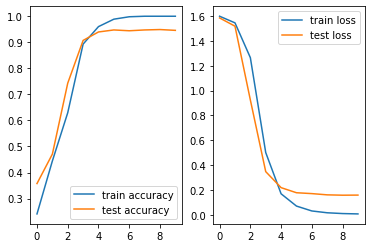

In [41]:
plt.subplot(1,2,1)
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='test accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend()

plt.show()

In [37]:
# build model with more layers

i = Input(shape=(T,))
x = Embedding(V+1, D)(i)
x = Conv1D(32, 3, activation='relu')(x)
# i think the 3 in MaxPooling1D is just the factor to reduce the image by, not the channels
x = MaxPooling1D(3)(x) 
x = Conv1D(64, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)

model = Model(i, x)
model.summary()


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 3497)]            0         
                                                                 
 embedding_9 (Embedding)     (None, 3497, 50)          1394200   
                                                                 
 conv1d_15 (Conv1D)          (None, 3495, 32)          4832      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 1165, 32)         0         
 1D)                                                             
                                                                 
 conv1d_16 (Conv1D)          (None, 1163, 64)          6208      
                                                                 
 global_max_pooling1d_9 (Glo  (None, 64)               0         
 balMaxPooling1D)                                          

In [38]:
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

r = model.fit(
    df_train['text_vec'].tolist(),
    df_train['labels'].tolist(),
    epochs=10,
    validation_data = (
        df_test['text_vec'].tolist(),
        df_test['labels'].tolist()
    )
)


Epoch 1/10
48/48 [==============================] - 29s 589ms/step - loss: 1.5998 - accuracy: 0.2410 - val_loss: 1.5861 - val_accuracy: 0.3576
Epoch 2/10
48/48 [==============================] - 19s 387ms/step - loss: 1.5465 - accuracy: 0.4442 - val_loss: 1.5197 - val_accuracy: 0.4706
Epoch 3/10
48/48 [==============================] - 17s 354ms/step - loss: 1.2661 - accuracy: 0.6295 - val_loss: 0.9249 - val_accuracy: 0.7430
Epoch 4/10
48/48 [==============================] - 18s 368ms/step - loss: 0.5010 - accuracy: 0.8931 - val_loss: 0.3473 - val_accuracy: 0.9071
Epoch 5/10
48/48 [==============================] - 18s 386ms/step - loss: 0.1686 - accuracy: 0.9602 - val_loss: 0.2182 - val_accuracy: 0.9396
Epoch 6/10
48/48 [==============================] - 14s 297ms/step - loss: 0.0697 - accuracy: 0.9887 - val_loss: 0.1772 - val_accuracy: 0.9474
Epoch 7/10
48/48 [==============================] - 11s 237ms/step - loss: 0.0303 - accuracy: 0.9980 - val_loss: 0.1702 - val_accuracy: 0.9443

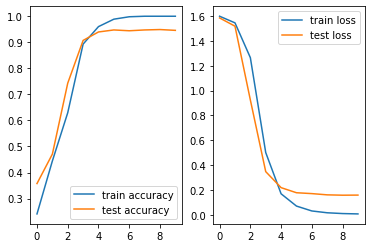

In [39]:
plt.subplot(1,2,1)
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='test accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend()

plt.show()